# Visualización de las activaciones de ConvNets

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Es útil entender cómo se activan los diferentes filtros contenidos en cada capa, y poder ver cómo estas activaciones van siendo cada vez mas alejadas de la imágen original, cada vez mas abstractas.

Vamos a ilustrar esta visualización con un modelo secuencial creado desde cero con 4 capas convolucionales (seguidas por max pooling) y 2 capas densas, aplicado al problema de clasificación binaria de perros y gatos.

Este modelo fue previamente entrenado, y se hizo persistencia en disco. Vamos entonces a cargarlo desde un archivo.

Lo primero que se debe hacer es crear el modelo vació sobre el cual se va an cargar los pesos

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # La capa adicional de regularización agregada
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Ahora que la estructura del modelo ya está en pié, vamos a cargar los pesos.

In [3]:
from keras.models import load_model
model = load_model('C:/Users/Javier/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/cats_and_dogs_small_2_dataaug.h5')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Ya tenemos entonces el modelo cargado.

Ahora vamos a cargar en memoria una de las imágenes de gatos que no fué utilizada durante el aprendizaje. Tenemos que pre-procesarla para que quede como las imágenes utilizadas para el entrenamiento del modelo (tamaño 150x150, normalización de la escala de colores a [0;1]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Cargamos la imagen en un tensor
img_path = 'C:/Users/Javier/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor =  image.img_to_array(img)
print(img_tensor.shape)

(150, 150, 3)


(1, 150, 150, 3)


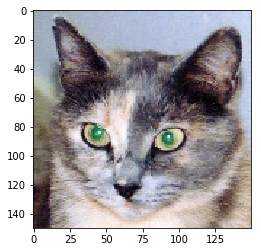

In [6]:
# Hay que agregar un eje al comienzo (posición 0, eje del batch) para poder estar de acuerdo con los inputs que recibe 
# el modelo (el eje del sample)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255. # Ojo: el . es necesario para cambiar el tipo a float
print(img_tensor.shape)

plt.imshow(img_tensor[0])

plt.show()

Vamos a crear un modelo Keras a partir de la clase **Model**, que se instancia con dos argumentos:
* Uno o varios tensores de entrada. En nuestro caso, solo vamos a tener un solo tensor; la imagen del gato anterior.
* Uno o varios tensores de salida. En nuestro caso, varios tensores con las activaciones de las capas convolucionales y de pooling (son las primeras 8 capas).

El resultado es un modelo que transforma los inputs a través de las primeras 8 capas, y permite obtener las activaciones de cada una delas capas especificadas.

In [7]:
from keras import models

# Los outputs de las primeras 8 capas: 4 Conv2D + 4 maxPooling2D
layer_outputs = [layer.output for layer in model.layers[:8]]
# Se crea un modelo con la misma capa de entrada y que retorna las capas especificadas
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Teníamos inicialment un modelo convolucional que recibía una imagen como entrada y la clasificaba en perro o gato.
Tenemos ahora además un modelo que retorna las activaciones de las primeras 8 capas, un modelo con una entrada y 8 salidas.

Vamos a pasar la imagen del gato por el modelo que obtiene las activaciones.

In [8]:
# Vamos a obtener una lista con los 8 conjuntos de activaciones de cada capa
# cada conjunto de activaciones tiene un array con los diferentes feature maps de los filtros correspondientes
activations = activation_model.predict(img_tensor)
len(activations)

8

Vamos a considerar las activaciones de la primera capa (índice 0), que produce un tensor de 1x148x148x32, y a visualizar el resultado de aplicar el 3er filtro convolucional.

In [9]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


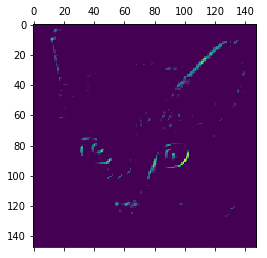

In [51]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

Este canal parece mostrar las activaciones a partir de filtros diagonales.

Vamos ahora a crear un plot que incluya los plots de los 8 mapas de activacion de todas las capas.

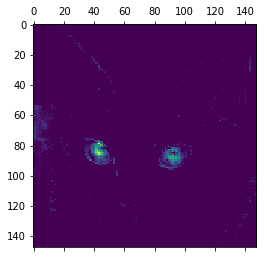

In [40]:
plt.matshow(first_layer_activation[0, :, :, 26], cmap='viridis')
plt.show()

Este canal parece ser sensible a los ojos del gato.

Vamos ahora a mostrar una matrix con todas las activaciones.

C:\Users\Javier\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


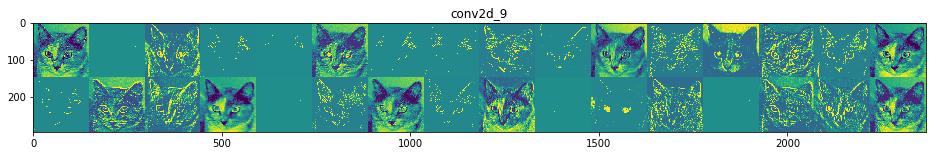

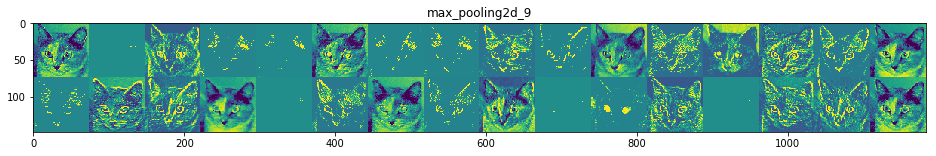

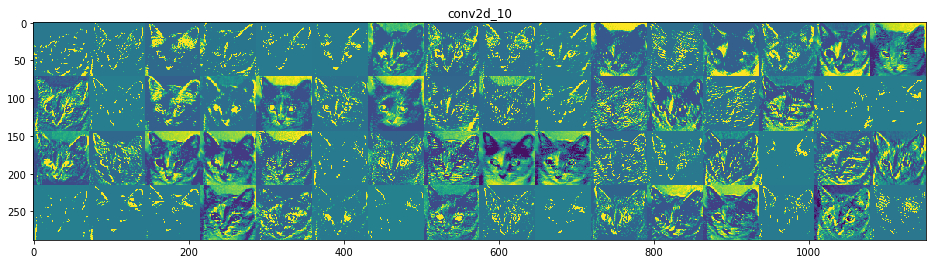

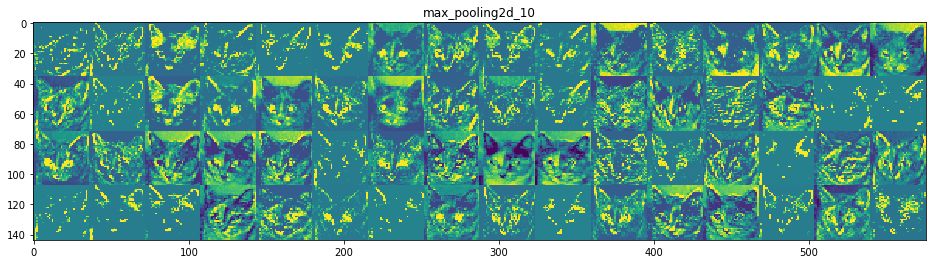

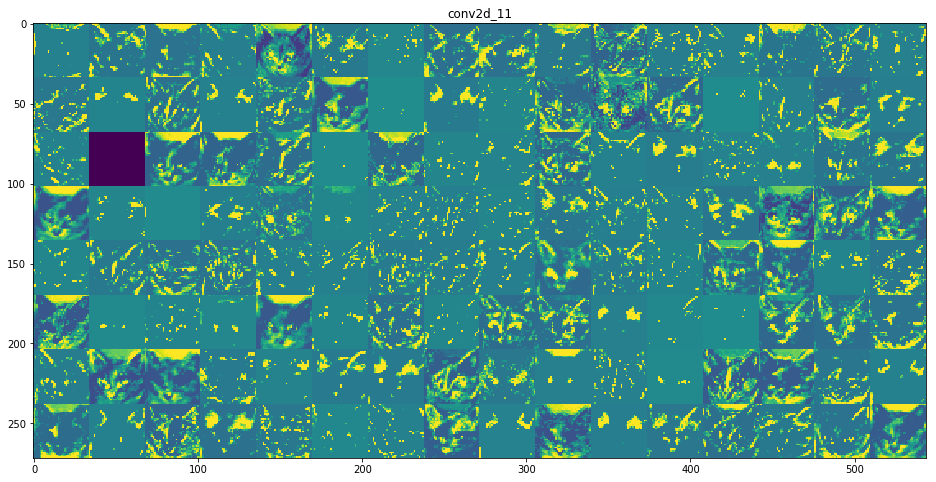

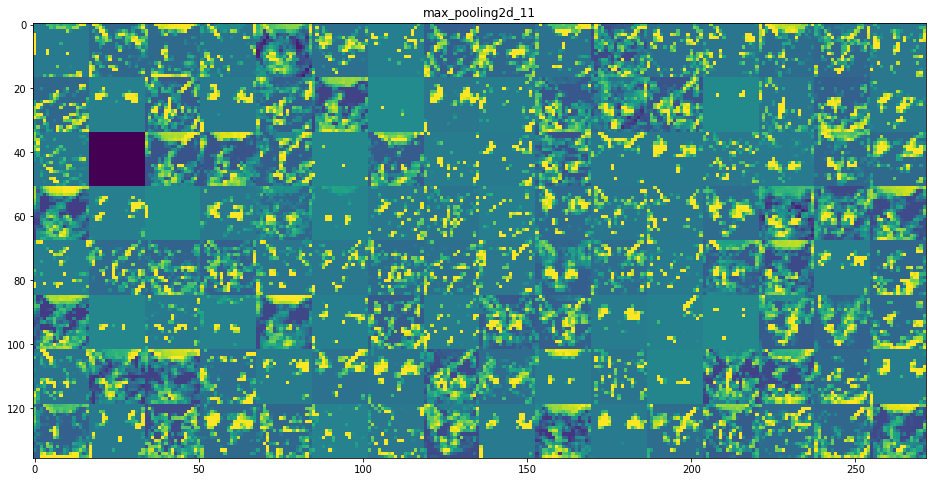

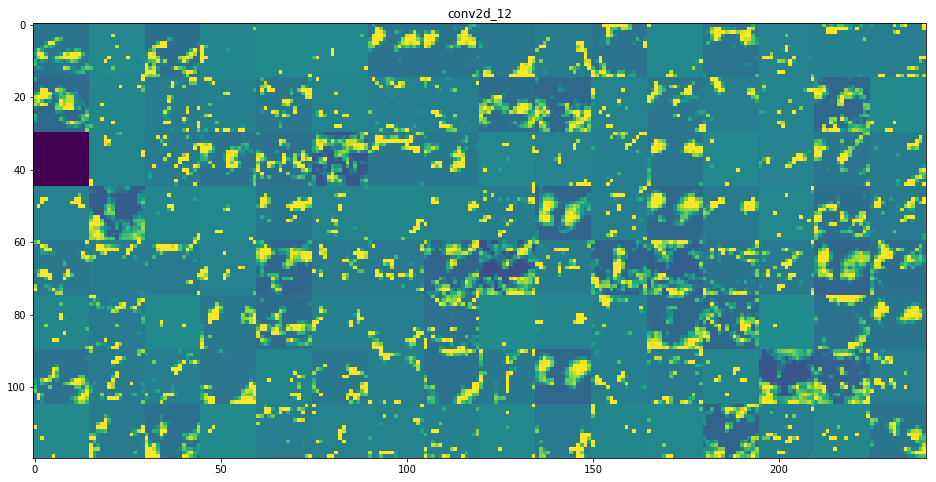

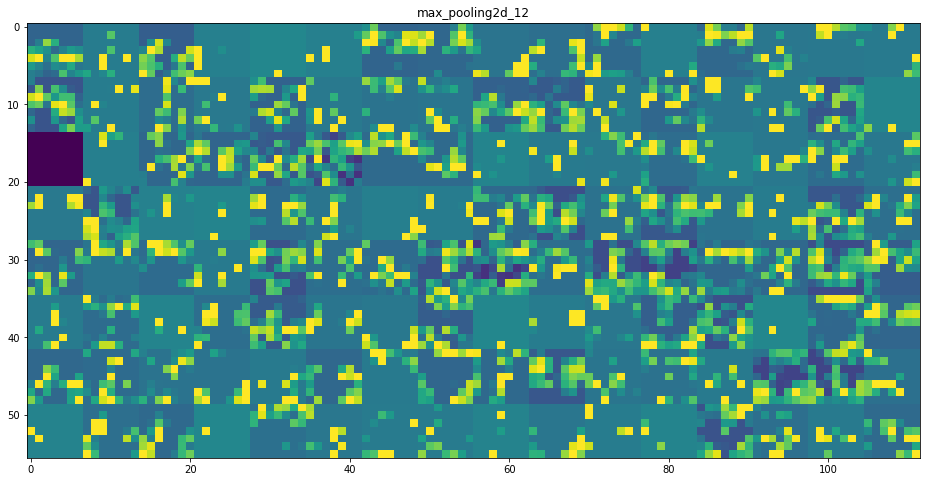

In [52]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Podemos ver que:
* La primera capa actúa como una colección de varios detectores de bordes. En este punto, las activaciones conservan casi toda la información presente en la imagen original.
* Mientras mas avanzamos en las capas, las activaciones se vuelven cada vez mas abstractas, y menos fáciles de interpretar, codificando conceptos cada vez más complejos, con cada vez menos información acerca de los contenidos visuales de las imágenes, y cada vez mas información acerca de las clases finales de la imágen.
* Entre más profunda la capa, cada vez es más difícil que esta se active por la imagen, lo que significa que el patrón extraido por el filtro no se encuentra en la imágen.

Una red de DL actúa como una tubería de distilación de información, con datos crudos que entran (imágenes RGB en este caso), y que son sucesivamente transformados de tal manera que información irrelevante para la tarea de clasificación es filtrada y desechada, dejando información útil que es magnificada y refinada (hasta llegar a la clase de la imagen).